<a href="https://colab.research.google.com/github/liyalapierre/cyclones-kalman-filter/blob/main/KalmanFilterCyclones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**INTRODUCTION**

In this project, we will be using the Kalman filter to track the path of tropical cyclones and predict the next location as the cyclone is traveling. Tracking tropical cyclones accurately is important, as it gives people time to prepare if you can know ahead of time where a cyclone will end up. The application of the Kalman filter is done in the simplest way by predicting future paths of travel using the positional data of the cyclones center. Using cyclone data, we will be able to derive and apply a Kalman filter to more accurately track cyclone paths and predict future locations. 

###**OUR DATA**

A description of the source of the data, including all necessary links to data sources, where possible. The file will also perform all the necessary preprocessing of the data, as you performed in your analysis. This should allow a reader to obtain the data and reproduce your data preprocessing. 

We are using data from the Atlantic Hurricane Database (HURDAT2) provided by NOAA. This dataset contains records of “six-hourly information on the location, maximum winds, central pressure, and (beginning in 2004) size of all known tropical cyclones and subtropical cyclones”. This data can be downloaded from this website:

https://www.nhc.noaa.gov/data/#hurdat

####Import Libraries:

In [ ]:
!pip install pykalman -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats, special
import seaborn as sns 
sns.set_style("whitegrid")
from numpy.linalg import inv
from pykalman import KalmanFilter

#### Data Preparation

In [ ]:
# url to downloaded txt file on Github
url = "https://raw.githubusercontent.com/liyalapierre/cyclones-kalman-filter/main/hurdat2-nepac-1949-2020-043021a.txt"

# column names (based on HURDAT2 documentation)
cols = ["Date", "Time_UTC", "Record_ID", "Status", "Latitude", "Longitude", "Max_Sust_Wind", "Max_Pressure", 
        "Wind_34_NE", "Wind_34_SE", "Wind_34_SW", "Wind_34_NW", "Wind_50_NE", "Wind_50_SE", "Wind_50_SW", "Wind_50_NW", "Wind_64_NE", "Wind_64_SE",
        "Wind_64_SW", "Wind_64_NW"]

# creating data frame w/ specified column names
data = pd.read_csv(url, names = cols, index_col=False) 

# limiting to just columns we want
data = data.iloc[:, [0, 1, 4, 5]]

# viewing head of data frame
data.head()

,Date,Time_UTC,Latitude,Longitude
0,EP011949,UNNAMED,NaN,NaN
1,19490611,0000,20.2N,106.3W
2,19490611,0600,20.2N,106.4W
3,19490611,1200,20.2N,106.7W
4,19490611,1800,20.3N,107.7W


In [ ]:
# Removing direction characters from latitude column
for row in range(len(data.iloc[:, 2])):
  if pd.isnull(data.iloc[row, 2]) == False:
    data.iloc[row, 2] = data.iloc[row, 2].replace("N", "")
    data.iloc[row, 2] = data.iloc[row, 2].replace("S", "")

# Removing direction characters from longtitude column
for row in range(len(data.iloc[:, 3])):
  if pd.isnull(data.iloc[row, 3]) == False:
    data.iloc[row, 3] = data.iloc[row, 3].replace("E", "")
    data.iloc[row, 3] = data.iloc[row, 3].replace("W", "")

In [ ]:
# Converting to int
data["Latitude"] = data["Latitude"].astype('float')
data["Longitude"] = data["Longitude"].astype('float')

In [ ]:
# subsetting specific hurricanes as smaller datasets (without header rows)
norbert = data.iloc[30618:30661,]
marie = data.iloc[30566:30617,] # we don't use this data in this project

###**OUR MODEL**

Our system model can be seen at the link below. The assumptions made are that the velocity is random with intial velocities set to 0, and that the noise associated with position and velocity is standard gaussian noise. Our model also assumes that latitude and longitude can be represented as planar coordinates while in reality they are spherical. This is because the overall travel of the tropical cyclones is small enough that the error of conversion is acceptable.

https://drive.google.com/file/d/1yr4XlP93wTbJd97kwdWoOiJMf0HV1RE8/view?usp=sharing

###**RESULTS**

Resources we used for our code:

https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html


https://pykalman.github.io/#pykalman.KalmanFilter.em

https://machinelearningspace.com/2d-object-tracking-using-kalman-filter/


First, let's visualize the observed states of our cyclone.

Text(0, 0.5, 'Longitude')

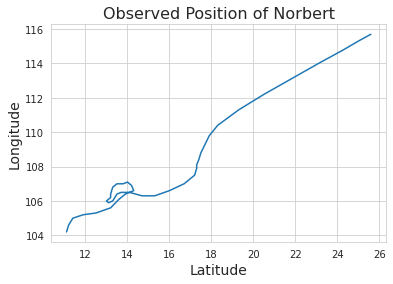

In [ ]:
# Plotting Norbert's Observed Path

x = norbert["Latitude"]
y = norbert["Longitude"]
plt.plot(x, y)

plt.title("Observed Position of Norbert", size = 16)
plt.xlabel("Latitude", size = 14)
plt.ylabel("Longitude", size = 14)

In [ ]:
# What is the starting point?
print("Initial Latitude: ", norbert.iloc[0,2])
print("Initial Longitude: ", norbert.iloc[0,3])

Initial Latitude:  11.1
Initial Longitude:  104.2


#### Estimating parameters with all of our variables

First we need to estimate the state covariance matrix and the observed noise covariance from our dataset. We will be using the EM algorithm from PyKalman to do this. 

In [ ]:
# this block sets up the KalmanFilter with our known matrices and our best guesses

# setting time interval (6 hr time interval between measurements)
dt=6

# setting up initial state of data and velocity
ism=[norbert.iloc[0,2], 0, norbert.iloc[0,3], 0]

# transition matrix
A = np.array([[1,dt,0,0],
              [0,1,0,0],
              [0,0,1,dt],
              [0,0,0,1]])

# observation matrix
C = np.array([[1,0,0,0],
              [0,0,1,0]])

# variables for state covariance matrix
thirdt=(1/3)*(dt**2)
halft=(1/2)*dt

# guess for state covariance matrix
state_cov_matrix_guess = np.array([[thirdt, halft, 0., 0.], 
                                   [halft, 1.0, 0., 0.],
                                   [0., 0., thirdt, halft],
                                   [0., 0., halft, 1.0]])

# guess for observed noise covariance
obs_std_guess = np.array([[1., 0],
                          [0, 1.]])

# inputting above matrices into the model
kf_learn = KalmanFilter(initial_state_mean = ism,
                        transition_matrices = A, 
                        observation_matrices = C, 
                        transition_covariance = state_cov_matrix_guess, 
                        observation_covariance = obs_std_guess**2, 
                        em_vars=['transition_covariance', 'observation_covariance'])

In [ ]:
# applying the em method to learn based on the observed data

# just the lat/long columns
xy = norbert.iloc[:, [2,3]]

# applying em
kf_learn = kf_learn.em(xy, n_iter = 10)

# saving the estimated transition covariance / observation covariance to variable
est_trans_cov = kf_learn.transition_covariance
est_obs_cov = kf_learn.observation_covariance

#### Kalman filter with estimated parameters

Now that we have estimated the state covariance matrix and the observed noise covariance from our dataset, we can input those into the Kalman Filter to get our filtered/estimated states. 

In [ ]:
# setting up the kalman filter with the parameters we just estimated
kf = KalmanFilter(initial_state_mean = ism, 
                  transition_matrices = A, 
                  observation_matrices = C, 
                  transition_covariance = est_trans_cov, 
                  observation_covariance = est_obs_cov)

In [ ]:
# using the kalman filter to give us the estimated states
(filtered_state_means, filtered_state_covariances) = kf.filter(xy) 

Text(0, 0.5, 'Longitude')

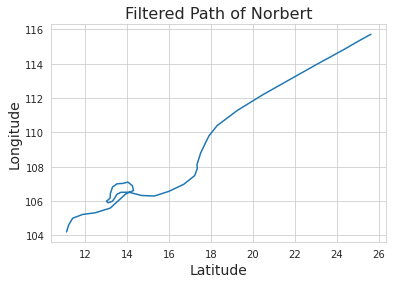

In [ ]:
# plotting the estimated states
plt.plot(filtered_state_means[:,0],filtered_state_means[:,2])
plt.title("Filtered Path of Norbert", size = 16)
plt.xlabel("Latitude", size = 14)
plt.ylabel("Longitude", size = 14)

#### Predicting next state

Now that we have successfully used the Kalman Filter to filter our existing data

In [ ]:
# using the kalman filter update feature to tell us the next state & covariance values
next_mean, next_covariance = kf.filter_update(filtered_state_means[-1], filtered_state_covariances[-1])

In [ ]:
# what is the next predicted location?
print("Next location in 6 hours will be: (", next_mean[0], ", ", next_mean[2], ")")

Next location in 6 hours will be: ( 26.283305577066773 ,  116.16666139108358 )


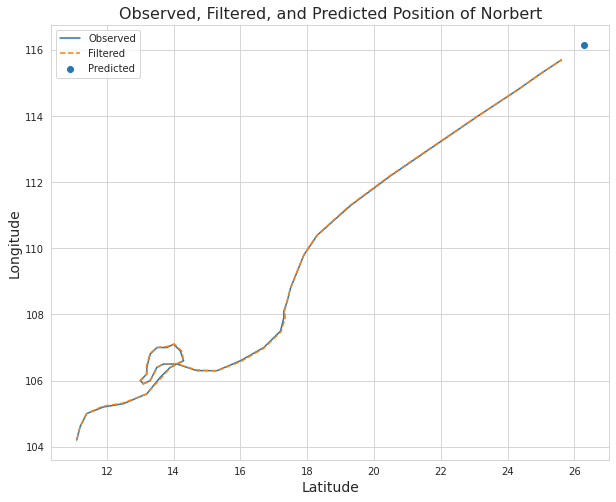

In [ ]:
# plotting observed, filtered, and predicted states

plt.subplots(figsize = (10, 8))

plt.plot(x, y, label = "Observed")
plt.plot(filtered_state_means[:,0],filtered_state_means[:,2], "--", label = "Filtered")
plt.scatter(next_mean[0],next_mean[2], label = "Predicted")

plt.title("Observed, Filtered, and Predicted Position of Norbert", size = 16)
plt.xlabel("Latitude", size = 14)
plt.ylabel("Longitude", size = 14)
plt.legend(loc = "best")

###**DISCUSSION**

Using our system model, we were able to use kalman filtering as well as prediction to accurately filter and predict future location data for tropical storms. As it can be seen in the observed, filtered, and predicted position graph, our system parameters accurately represent our system as the overlap between filtered and predicted data with the measured data is near perfect. It does appear that the observed data may not have a significant amount of noise in the measurements, and therefore the Kalman filter predicted states barely differ from the measured states. 

Assuming that other cyclones would perform similarly under the kalman filter, this program will be able to accurately predict the latitude and longitude of storms in the HURDAT2 database 1 time step in the future, which is 6 hours. Giving 6 additional hours of warning to people in the path of travel of these storms will give them the ability to better prepare for the storm and to find additional shelter if needed. 